In [60]:
import pickle
import itertools
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pathlib

In [61]:
dataset_name = "kannyou"

In [62]:
## mask.csvように書き換える
class metashape_Camera:
    def __init__(self, val):
        self.img_num = val
        inner_para_path = pathlib.Path("../view_mats/{}_view_mat/inner_para.csv".format(dataset_name))
        self.A = np.loadtxt(str(inner_para_path), delimiter=",")

    def img_load(self):
        folder_path = "../images/{}".format(dataset_name)
        file_path = os.path.join(folder_path, str(self.img_num) + ".JPG")
        img = cv2.imread(file_path, 1)# BGRで読み込み
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = cv2.flip(img, 1) # 反転 unity用?
        self.img = img # 画像(ndarray)
        self.img_shape = img.shape

    def mask_load(self):
        folder = pathlib.Path("../masks/{}_mask".format(dataset_name))
        masks_path = list(folder.glob(str(self.img_num)+"_"+"*"+".png"))
        if masks_path == []:
            zero_mask = np.zeros(self.img_shape).astype("int8")
            mask_path = "../masks/{}_mask/".format(dataset_name) + str(self.img_num)+"_"+"0"+".png"
            cv2.imwrite(mask_path, zero_mask)
            masks_path = [mask_path]

        mask_list = []
        for mask_path in masks_path:
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            mask_list.append(mask)
        self.masks = np.asarray(mask_list).transpose(1, 2, 0)
        
    def para_load(self, viwe_mat_path="../view_mats/{}_view_mat/".format(dataset_name)):
        folder_path = pathlib.Path(viwe_mat_path)
        file_path = os.path.join(folder_path, str(self.img_num)+".csv")
        self.Rt = np.loadtxt(file_path, delimiter=",")
        self.Rt = np.linalg.pinv(self.Rt)
        self.P = np.dot(self.A, self.Rt[0:3,0:4])
        self.cam_world_cood = -np.dot(self.Rt[0:3,0:3].T, self.Rt[0:3,3])
        
def cood_to_mask(csv_path, im_shape):
    idx = np.loadtxt(str(csv_path), delimiter=",")
    idx = idx.astype(np.int64)
    
    mask = np.zeros(im_shape, dtype=np.uint8)
    
    if idx.size == 0:
        return mask
    
    mask[idx[0],idx[1]] = 255
    return mask

def normalization(vec3):
    return np.array([vec3[:,0]/vec3[:,2], vec3[:,1]/vec3[:,2]]).T

In [63]:
def norm(vec):
    s_vec = np.square(vec)
    sume = np.sum(s_vec)
    ss = np.sqrt(sume)
    return vec/ss

In [64]:
pcd = o3d.io.read_point_cloud("polygon/{}/{}_ds_denoise.ply".format(dataset_name, dataset_name))

#labels = np.array(pcd.cluster_dbscan(eps=0.1, min_points=100))
with open(r"polygon/{}/{}_point_cloud_label.pickle".format(dataset_name, dataset_name), 'rb') as f:
    labels = pickle.load(f)

max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

LABELS = labels
PCD = pcd

class LabelProp:
    
    def __init__(self, val, pcd, labels):
        self.num = val
        self.LABELS = labels
        self.PCD = pcd
        
    def cam_load(self):
        test = metashape_Camera(self.num)
        test.img_load()
        test.mask_load()
        test.para_load()
        self.cam = test
    
    def point_cloud_load(self):
        #pcd = o3d.io.read_point_cloud("denoise.ply")

        #with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
        #labels = np.array(pcd.cluster_dbscan(eps=0.1, min_points=100))

        #max_label = labels.max()
        #colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
        #colors[labels < 0] = 0
        #pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
        
        self.pcd = self.PCD
        self.labels = self.LABELS
        u, counts = np.unique(self.labels, return_counts=True)
        self.pt_counts = counts
    
    def pc_prop(self):
        # 点群加工
        camera = self.cam.cam_world_cood
        diameter = np.linalg.norm(
            np.asarray(self.pcd.get_max_bound()) - np.asarray(self.pcd.get_min_bound()))

        #camera = cam_world_cood
        radius = diameter*1000
        
        self.pre_pt = pcd.points
        self.pre_pt = np.concatenate([np.asarray(self.pre_pt), np.ones((np.asarray(self.pre_pt).shape[0],1))], axis=1)

        _, pt_map = self.pcd.hidden_point_removal(camera, radius)
        self.pcd = self.pcd.select_by_index(sorted(pt_map))

        self.TD_points = np.concatenate([np.asarray(self.pcd.points), np.ones((np.asarray(self.pcd.points).shape[0],1))], axis=1)
        self.pre_labels = self.labels
        self.labels = self.labels[np.array(sorted(pt_map))]
        
#    def pc_labeling_menber(self):
#        repro_points = normalization((self.cam.P@self.TD_points.T).T)
#        repro_points = np.round(repro_points).astype(np.int64)
#        
#        idx = (repro_points[:,0]>0) & (repro_points[:,0]<self.cam.img_shape[1]) & (repro_points[:,1]>0) & (repro_points[:,1]<self.cam.img_shape[0])
#        
#        self.repro_points = repro_points[idx]
#        self.labels = self.labels[idx]
        
    def pc_labeling_menber(self):
        self.repro_points, self.labels = pc_labeling(self.TD_points, self.cam.P, self.cam.img_shape, self.labels)
        self.pre_repro_pt, self.pre_labels = pc_labeling(self.pre_pt, self.cam.P, self.cam.img_shape, self.pre_labels)
        
    def labeling(self):
        overrap_list = np.zeros((labels.max().astype(int)+1 , self.cam.masks.shape[2]))
        for j in np.unique(self.labels):
            temp_overrap_list = []
            zero_mask = np.zeros([self.cam.masks.shape[0],self.cam.masks.shape[1]])
            zero_mask[self.repro_points[self.labels==j][:,1], self.repro_points[self.labels==j][:,0]] = 1
            for i in range(self.cam.masks.shape[2]):
                temp_overrap_list.append(np.sum((zero_mask>0) * (self.cam.masks[:,:,i]>0)))
            overrap_list[int(j),:] = np.array(temp_overrap_list)
        all_zero_idx = np.all(overrap_list==0, axis=0)
        label = np.argmax(overrap_list, axis=0).astype("float64")
        self.repro_point_num = np.max(overrap_list, axis=1)
        label[all_zero_idx] = np.nan
        self.output_label = label
        
    def calc_occlusion(self):
        counts = self.pt_counts
        occlusion = self.repro_point_num/counts
        self.occlusion = occlusion
        
        
def pc_labeling(TD_points, P_mat, img_shape, labels):
    repro_points = normalization((P_mat@TD_points.T).T)
    repro_points = np.round(repro_points).astype(np.int64)    
    idx = (repro_points[:,0]>0) & (repro_points[:,0]<img_shape[1]) & (repro_points[:,1]>0) & (repro_points[:,1]<img_shape[0])
    repro_points = repro_points[idx]
    labels = labels[idx]
    return repro_points, labels

def prop_all(num, pcd, labels):
    lp = LabelProp(num, pcd, labels)
    lp.cam_load()
    lp.point_cloud_load()
    lp.pc_prop()
    lp.pc_labeling_menber()
    lp.labeling()
    lp.calc_occlusion()
    return lp.output_label, lp.occlusion

In [65]:
l = []
o = []
for i in range(120): 
    label, occlusion = prop_all(i, pcd, labels)
    l.append(label)
    o.append(occlusion)
    print(i)


with open("../labels/{}_label.pickle".format(dataset_name), 'wb') as f:
    pickle.dump(l, f)
        
with open("../labels/{}_occlusion.pickle".format(dataset_name), 'wb') as f:
    pickle.dump(o, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [66]:
l

[array([ 0.,  2., 15.]),
 array([15.,  0.,  2.]),
 array([ 2.,  0., 15.]),
 array([15.,  2.,  0.]),
 array([ 0., 15.,  2.]),
 array([ 2.,  0., 15.]),
 array([ 2., 15.,  0.]),
 array([ 0., 15.,  2.]),
 array([15.,  0.,  2.]),
 array([ 0.,  2., 15.]),
 array([15.,  0.,  2.]),
 array([ 2.,  0., 15.]),
 array([15.,  2.,  0.]),
 array([ 2.,  0., 15.]),
 array([15.,  2.,  0.]),
 array([ 2., 15.,  0.]),
 array([ 0., 15.,  2.]),
 array([0., 2., 2.]),
 array([2., 0., 2.]),
 array([ 2.,  0., nan]),
 array([0., 2., 2.]),
 array([ 0.,  2., 15.]),
 array([15.,  2.,  0.]),
 array([15.,  2.,  2.]),
 array([ 2., 15.,  0.]),
 array([15.,  0.,  2.]),
 array([15.,  2.,  0.]),
 array([15.,  0.,  2.]),
 array([15.,  0.,  2.]),
 array([ 2.,  0., 15.]),
 array([ 2.,  0., 15.]),
 array([ 2.,  0., 15.]),
 array([ 2.,  0., 15.]),
 array([ 2., 15.,  0.]),
 array([ 0.,  2., 15.]),
 array([15.,  0.,  2.]),
 array([ 0.,  2., 15.]),
 array([ 0., 15.,  2.]),
 array([ 0., 15.,  2.]),
 array([ 0., 15.,  2.]),
 array([1

In [49]:
i = 2
test = metashape_Camera(i)
test.img_load()
test.mask_load
#test.contour_extraction()
test.para_load()

In [51]:
# クラスタリング
pcd = o3d.io.read_point_cloud("polygon/{}/{}_ds_denoise.ply".format(dataset_name, dataset_name))
with open(r"polygon/{}/{}_point_cloud_label.pickle".format(dataset_name, dataset_name), 'rb') as f:
    labels = pickle.load(f)


max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
#o3d.visualization.draw_geometries([pcd])

In [52]:
camera = test.cam_world_cood
diameter = np.linalg.norm(
    np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound()))

#camera = cam_world_cood
radius = diameter*10000

_, pt_map = pcd.hidden_point_removal(camera, radius)
pcd = pcd.select_by_index(sorted(pt_map))

TD_points = np.concatenate([np.asarray(pcd.points), np.ones((np.asarray(pcd.points).shape[0],1))], axis=1)

labels = labels[np.array(sorted(pt_map))]
#o3d.visualization.draw_geometries([pcd])

In [53]:
TD_points

array([[ 0.18540536, -0.19622807, -2.5173974 ,  1.        ],
       [ 0.15701497, -0.20704629, -2.50192213,  1.        ],
       [ 0.15068108, -0.19495052, -2.48607278,  1.        ],
       ...,
       [-0.0035588 ,  0.14003479, -2.36294937,  1.        ],
       [-0.0146537 ,  0.00956939, -2.29321933,  1.        ],
       [-0.04897052,  0.01889233, -2.29118299,  1.        ]])

In [54]:
repro_points = normalization((test.P@TD_points.T).T)
repro_points = np.round(repro_points).astype(np.int64)


In [55]:
repro_points

array([[2862, 2138],
       [2811, 2172],
       [2800, 2150],
       ...,
       [2395, 1436],
       [2429, 1741],
       [2345, 1729]], dtype=int64)

In [56]:
idx = (repro_points[:,0]>0) & (repro_points[:,0]<test.img_shape[1]) & (repro_points[:,1]>0) & (repro_points[:,1]<test.img_shape[0])

In [57]:
repro_points

array([[2862, 2138],
       [2811, 2172],
       [2800, 2150],
       ...,
       [2395, 1436],
       [2429, 1741],
       [2345, 1729]], dtype=int64)

In [58]:
repro_points = repro_points[idx]
labels = labels[idx]

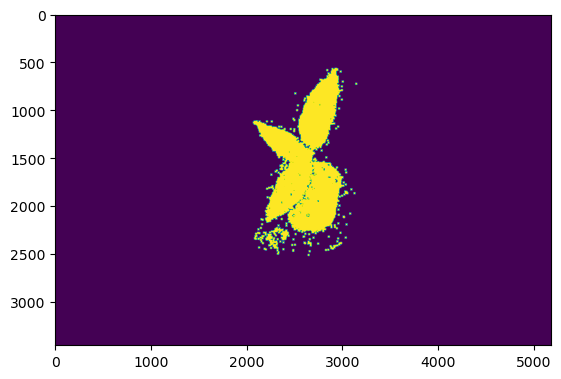

In [59]:
zero_mask = np.zeros([test.img_shape[0],test.img_shape[1]])
zero_mask[repro_points[:,1], repro_points[:,0]] = 1
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(zero_mask*255,kernel,iterations = 5)
plt.imshow(dilation)

In [14]:
l

[array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),
 array([nan, nan, nan]),


In [11]:
with open("../labels/{}_label.pickle".format(dataset_name), 'wb') as f:
    pickle.dump(l, f)
        
with open("../labels/{}_occlusion.pickle".format(dataset_name), 'wb') as f:
    pickle.dump(o, f)

In [6]:
with open("../labels/new_GmJMC025_02_occlusion.pickle", 'rb') as f:
    A = pickle.load(f)

In [19]:
lab_sup = [[31, 65], [33, 30], [34, 25], [35, 54], [37, 45], [38, 30], [45, 40]]

In [21]:
for i in range(len(lab_sup)):
    occ = np.average(A,axis=0)[lab_sup[i][0]]
    lab_sup[i].append(occ)

In [22]:
lab_sup

[[31, 65, 0.16552331309580878],
 [33, 30, 0.1428033521279061],
 [34, 25, 0.11937498377087066],
 [35, 54, 0.1634298093150961],
 [37, 45, 0.1495980987187017],
 [38, 30, 0.1322910359542139],
 [45, 40, 0.1704730229120474]]

In [23]:
with open("real_opt_sup_th.pickle", 'wb') as f:
    pickle.dump(lab_sup, f)

In [7]:
with open("../labels/new_GmJMC025_02_label.pickle", 'rb') as f:
    B = pickle.load(f)

(array([34.,  3.,  2.,  0.,  0.,  0.,  0.,  2.,  2.,  3.]),
 array([0.        , 0.0170473 , 0.0340946 , 0.05114191, 0.06818921,
        0.08523651, 0.10228381, 0.11933112, 0.13637842, 0.15342572,
        0.17047302]),
 <BarContainer object of 10 artists>)

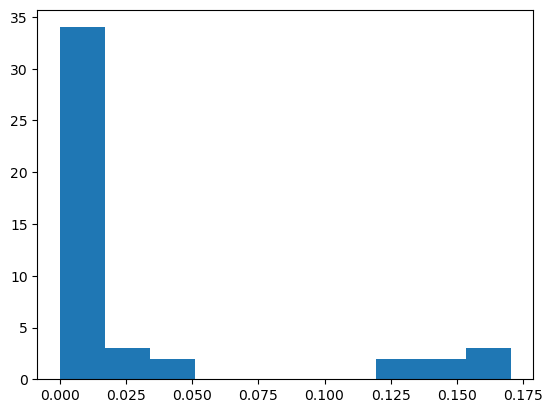

In [8]:
plt.hist(np.average(np.stack(A), axis=0))

In [9]:
u, counts = np.unique(np.concatenate(B), return_counts=True)

In [10]:
counts

array([ 52,  45,  79,  17,  19,   3,  12,  14,   4, 136,  22, 303, 209,
       242, 235, 241, 183,   5, 198,  31], dtype=int64)

In [11]:
u

array([ 0.,  1.,  3.,  4.,  7.,  8., 11., 12., 13., 15., 21., 31., 33.,
       34., 35., 37., 38., 39., 45., nan])